In [501]:
import pandas as pd
import numpy as np
import re
import itertools
from yaml import safe_dump
from matplotlib import pyplot as plt
import seaborn as sns
import json
import ipaddress
import os
import glob
import scipy.stats

sns.set_style("whitegrid")
%matplotlib inline

In [502]:
# Configuration
ZONE = 'ROOT'
INPUT_DIR = '%s/edns_comp_result' % ZONE

In [503]:
def json_dump(data, file_pat, loc=None):
    with open(file_pat.format(**loc), 'w') as f:
        json.dump(data, f)

In [504]:
lookup_re = re.compile('((address|AAAA|A) lookup[s]? failed|no address records found|nameserver is a CNAME|A nxdomain)')

In [505]:
file_date_re = re.compile('(ednscompresult\-)?(\d{4}\-\d{2}\-\d{2})')

In [506]:
lookup_errors = []
data = []
file_dates = []
for INPUT_FILE in glob.glob("%s/edns*" % INPUT_DIR):
    # Parse the input file to extract a date
    file_match = file_date_re.search(INPUT_FILE)
    if file_match is not None:
        file_dates.append(file_match.group(2))
    # The input file has a mix of lookup errors and the test results properly formatted
    with open(INPUT_FILE, 'r') as f:
        for l in f.readlines():
            if lookup_re.search(l):
                lookup_errors.append(l.strip("\n"))
            else:
                p = l.strip("\n").lower().split(' ')
                try:
                    entry = {'domain': p[0], 'address': p[1], 'server': p[2], 'src_file': INPUT_FILE}
                    for i in range(3, len(p)):
                        l, e = p[i].split('=')
                        entry[l] = e
                    data.append(entry)
                except ValueError:
                    print("Line with bad format? %s" % l)
                except IndexError:
                    # print("Not enough fields in %s" % l)
                    lookup_errors.append(l.strip("\n"))

In [507]:
FILE_DATE = scipy.stats.mode(file_dates)[0][0]
LOC_DATA = {'zone': ZONE, 'date': FILE_DATE}

/opt/a/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [508]:
LOC_DATA

{'date': '2018-10-08', 'zone': 'ROOT'}

In [509]:
# Save the lookup errors directly into JSON
json_dump(lookup_errors, '{zone}/{zone}-lookup-errors-{date}.json', loc={'zone': ZONE, 'date': FILE_DATE})

In [510]:
d0 = pd.DataFrame(data)

In [511]:
d0.head(5)

,aa,ad,address,cd,dns,do,docd,domain,edns,edns1,...,optlist,ra,rd,server,signed,src_file,tc,tcp,type666,zflag
0,ok,ok,@198.41.0.4,ok,ok,ok,ok,.,ok,ok,...,ok,ok,ok,(a.root-servers.net.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
1,ok,ok,@2001:503:ba3e::2:30,ok,ok,ok,ok,.,ok,ok,...,ok,ok,ok,(a.root-servers.net.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
2,ok,ok,@199.9.14.201,ok,ok,ok,ok,.,ok,ok,...,"ok,nsid",ok,ok,(b.root-servers.net.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
3,ok,ok,@2001:500:200::b,ok,ok,ok,ok,.,ok,ok,...,"ok,nsid",ok,ok,(b.root-servers.net.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
4,ok,ok,@192.33.4.12,ok,ok,ok,ok,.,ok,ok,...,"ok,nsid",ok,ok,(c.root-servers.net.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok


In [512]:
# This takes the multiple runs contained in the dataframe d0 and leave one entry per address
# taking the most frequent (mode) result for each column
d = d0.groupby(['address']).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()

/opt/a/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [513]:
d.head(5)

,address,aa,ad,cd,dns,do,docd,domain,edns,edns1,...,optlist,ra,rd,server,signed,src_file,tc,tcp,type666,zflag
0,@103.19.177.177,ok,ok,ok,ok,ok,ok,id.,ok,ok,...,ok,ok,ok,(e.dns.id.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
1,@103.19.178.178,ok,ok,ok,ok,ok,nocd,id.,ok,ok,...,ok,ok,ok,(c.dns.id.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
2,@103.19.179.179,ok,ok,ok,ok,ok,nocd,id.,ok,ok,...,ok,ok,ok,(b.dns.id.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
3,@103.198.210.1,ok,ok,ok,ok,ok,ok,jprs.,ok,ok,...,"ok,nsid",ok,ok,(tld4.nic.jprs.):,"ok,yes",ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok
4,@103.25.58.26,ok,ok,ok,ok,ok,ok,tg.,ok,ok,...,ok,ok,ok,(ns4.admin.net.):,ok,ROOT/edns_comp_result/ednscompresult-2018-10-08,ok,ok,ok,ok


In [514]:
le_split = re.compile('(([a-z0-9\-\.]+) ([a-z0-9\-\.]+): (.*)|([a-z0-9\-\.]+) ([a-z0-9\-\.]+))$', re.IGNORECASE)
def split_lookup_error(e):
    m = le_split.match(e)
    if m is None:
        return None
    elif m.group(2) is None:
        return {'domain': m.group(5), 'server': m.group(6), 'error': None}
    else:
        return {'domain': m.group(2), 'server': m.group(3), 'error': m.group(4)}

In [515]:
# [split_lookup_error(e) for e in some_errors]

In [516]:
# [e for e in lookup_errors if split_lookup_error(e) is None]
# le_df = pd.DataFrame([split_lookup_error(e) for e in lookup_errors])

In [517]:
# le_df.head(5)

le_s = pd.DataFrame(le_df['error'].value_counts())
le_s['Zone'] = ZONE
le_s.to_json('%s-lookup-error-summary.json' % ZONE)

le_s2 = le_df[['error', 'domain']].groupby(['error']).count().reset_index()
le_s2['Zone'] = ZONE
le_s2.to_json('%s-lookup-errors-per-domain.json' % ZONE)

le_df['domain'].nunique()

len(set(d['server'].unique()).union(set(le_df['server'].unique())))

# Create a high level summary with number of unique servers, addresses and domains, to normalize future results and aggregations
with open('%s-high-level-counts.json' % ZONE, 'w') as f:
    json.dump({'Zone': ZONE,
              'unique_dom': len(set(d['domain'].unique()).union(set(le_df['domain'].unique()))),
              'unique_server': len(set(d['server'].unique()).union(set(le_df['server'].unique()))),
              'unique_address': d['address'].nunique()},
             f)

In [518]:
d['family'] = d['address'].apply(lambda x: "v" + str(ipaddress.ip_address(x[1:]).version))

In [519]:
n_dom = d['domain'].nunique()
n_addr = d['address'].nunique()
n_server = d['server'].nunique()
uniq_v4_addr = d.query("family=='v4'")['address'].nunique()
uniq_v6_addr = d.query("family=='v6'")['address'].nunique()

In [520]:
def summary_per_family(data=None, field=None):
    g_fields = ['family', field]
    fields = g_fields + ['address']
    s = data[fields].groupby(g_fields).count().reset_index()
    s.columns = ['family', 'error_type', 'count']
    s['test'] = field
    
    return s

In [521]:
d.columns

Index(['address', 'aa', 'ad', 'cd', 'dns', 'do', 'docd', 'domain', 'edns',
       'edns1', 'edns1cookie', 'edns1do', 'edns1expire', 'edns1nsid',
       'edns1opt', 'edns1subnet', 'edns@512', 'ednscookie', 'ednsexpire',
       'ednsflags', 'ednsnsid', 'ednsopt', 'ednssubnet', 'ednstcp', 'opcode',
       'opcodeflg', 'optlist', 'ra', 'rd', 'server', 'signed', 'src_file',
       'tc', 'tcp', 'type666', 'zflag', 'family'],
      dtype='object')

In [522]:
high_summary = pd.concat([summary_per_family(data=d, field=f) for f in ['dns', 'edns', 'do', 'edns1', 'edns1opt', 'edns@512', 'ednsflags', 'ednsopt', 'ednstcp', 'optlist']]).reset_index()

In [523]:
high_summary.to_json('{zone}/{zone}-high-level-summary-{date}.json'.format(**LOC_DATA))

In [524]:
def explode_test(r, **kwargs):
    # This is a dataframe row, it should have address, domain, server and one extra field to split
    f = [a for a in r.keys() if a not in ['address', 'domain', 'server']][0]
    return [dict(list(r.items()) + [(f, v)]) for v in r[f].split(',')]

In [525]:
def old_summary_df(data=None, field=None):
    return pd.DataFrame([a for a in itertools.chain.from_iterable(data[['address', 'server', 'domain', field]].apply(explode_test, axis=1))])

In [526]:
def summary_df(data=None, field=None):
    row_list = []
    for index, row in data.iterrows():
        for vals in row[field].split(','):
            new_row = dict([(k, v) for k, v in row.items() if k in ['address', 'domain', 'server']])
            new_row[field] = vals
            row_list.append(new_row)
    
    return pd.DataFrame(row_list)

### Section 1: General DNS statistics

In [527]:
# Summary of errors for basic DNS test
s_dns = summary_df(data=d, field='dns')

In [528]:
s1 = s_dns.groupby(['dns']).count().reset_index()
s1['perc'] = 100* (s1['domain'] / s1['domain'].sum())
s1['error_type'] = s1.apply(lambda r: 'Other' if r['perc'] < 0.1 else r['dns'], axis=1)
s1b = s1[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
s1b['test'] = 'dns'
s1b

,error_type,perc,domain,test
1,ok,99.134449,6872,dns
2,timeout,0.721293,50,dns
0,Other,0.144259,10,dns


In [529]:
s1b.to_json('{zone}/{zone}-domain-test-results-{date}.json'.format(**LOC_DATA))

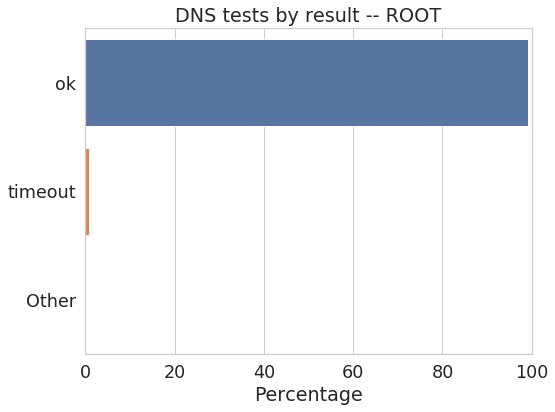

In [530]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s1b, x='perc', y='error_type')
ax.set(xlim=[0, 100], title='DNS tests by result -- %s' % ZONE, ylabel='', xlabel='Percentage')
plt.savefig('{zone}/{zone}-basic-DNS-test-{date}.png'.format(**LOC_DATA))

In [531]:
s1.head(2)

,dns,address,domain,server,perc,error_type
0,ok,6872,6872,6872,99.134449,ok
1,refused,5,5,5,0.072129,Other


In [532]:
s_dns.head(5)

,address,dns,domain,server
0,@103.19.177.177,ok,id.,(e.dns.id.):
1,@103.19.178.178,ok,id.,(c.dns.id.):
2,@103.19.179.179,ok,id.,(b.dns.id.):
3,@103.198.210.1,ok,jprs.,(tld4.nic.jprs.):
4,@103.25.58.26,ok,tg.,(ns4.admin.net.):


In [533]:
t_server_dns = s_dns[['dns', 'server', 'domain']].groupby(['server', 'dns']).count().reset_index()
# .pivot_table(index='server', columns='dns', values='domain', fill_value=0)

In [534]:
t_server_dns['frac'] = t_server_dns['domain'] / t_server_dns.groupby('server')['domain'].transform('sum')

In [535]:
t_server_dns.head(2)

,server,dns,domain,frac
0,(1.ns.ph.):,ok,2,1.0
1,(a-dns.pl.):,ok,2,1.0


In [536]:
frac_sum = t_server_dns['frac'].sum()

In [537]:
s_server_dns = (100 * (t_server_dns[['dns', 'frac']].groupby(['dns']).sum() / frac_sum)).reset_index().sort_values(by='frac', ascending=False)

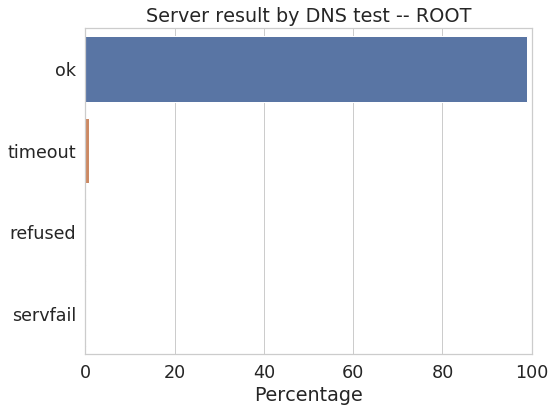

In [538]:
# Plot fraction of servers affected by each error at the DNS level
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s_server_dns, x='frac', y='dns')
ax.set(xlim=[0, 100], title='Server result by DNS test -- %s' % ZONE, ylabel='', xlabel='Percentage')
plt.savefig('%s-basic-DNS-test-per-server.png' % ZONE)
s_server_dns.to_json('{zone}/{zone}-basic-DNS-test-per-server-{date}.json'.format(**LOC_DATA))

### To analyze the tests properly, we need to describe them based on their dependencies. For example, if the dns test fails, the edns test is expected to fail.

![title](EDNS test decision tree.png)

In [539]:
def multiple_field_summary(data=None, fields=[]):
    slist = []
    for c in fields:
        if c in ['address', 'server', 'domain']:
            continue
        if c in ['dns'] and 'dns' not in fields:
            continue
        # temporary dataframe with the specific output
        tmp_s = summary_df(data=data, field=c)
        print("Column = %s" % c)
        sg = tmp_s.groupby([c]).count().reset_index()
        sg['perc'] = 100* (sg['domain'] / sg['domain'].sum())
        sg['error_type'] = sg.apply(lambda r: 'Other' if r['perc'] < 0.1 else r[c], axis=1)
        sg2 = sg[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
        sg2['test'] = c
        slist.append(sg2)
    
    return pd.concat(slist)

In [540]:
def plot_comparison(data=None, title=None, file_prefix=None, loc=None):
    sns.set(style='whitegrid', font_scale=1.6)
    plt.figure(figsize=(16,9))
    ax = sns.barplot(data=data, x='perc', y='error_type', hue='test', ci=None)
    ax.set(xlim=[0, 100], title=title % loc['zone'], ylabel='', xlabel='Percentage')
    plt.legend(loc='lower right')
    plt.savefig((file_prefix.format(**loc)) + ".png")
    data['zone'] = loc['zone']
    data.to_json((file_prefix.format(**loc)) + ".json", orient='records')

### Compare DNS results against plain EDNS results

In [541]:
s_dns_edns = multiple_field_summary(data=d[d['dns']=='ok'], fields=['dns', 'edns'])

Column = dns
Column = edns


In [542]:
s_dns_edns

,error_type,perc,domain,test
0,ok,100.000000,6872,dns
1,ok,99.883586,6864,edns
0,Other,0.116414,8,edns


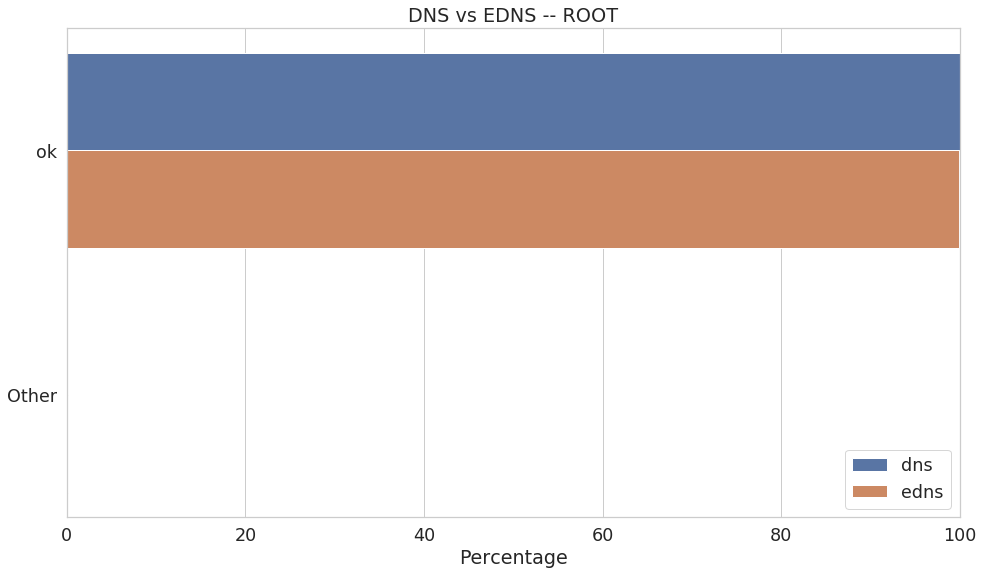

In [543]:
plot_comparison(data=s_dns_edns, title='DNS vs EDNS -- %s', file_prefix='{zone}/{zone}-DNS-EDNS-{date}', loc=LOC_DATA)

### Error summary by test and by server where dns=ok and where the test is 'edns' or 'edns1' 

In [544]:
s_edns_edns1 = multiple_field_summary(data=d[d['dns']=='ok'], fields=['edns', 'edns1'])

Column = edns
Column = edns1


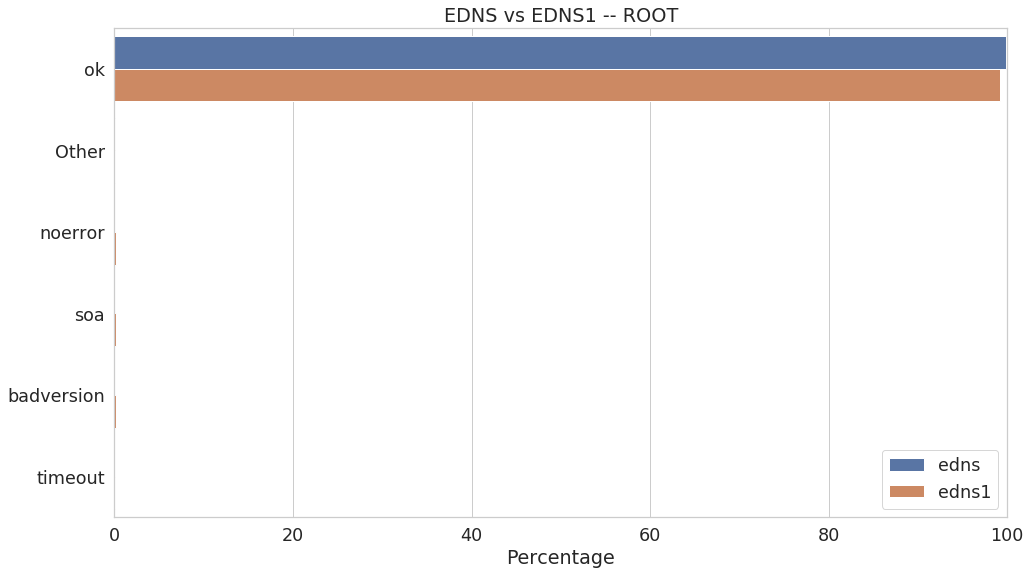

In [545]:
plot_comparison(data=s_edns_edns1, title='EDNS vs EDNS1 -- %s', file_prefix='{zone}/{zone}-EDNS-EDNS1-{date}', loc=LOC_DATA)

In [546]:
s_edns_ednsopt = multiple_field_summary(data=d[d['dns']=='ok'], fields=['edns', 'ednsopt'])

Column = edns
Column = ednsopt


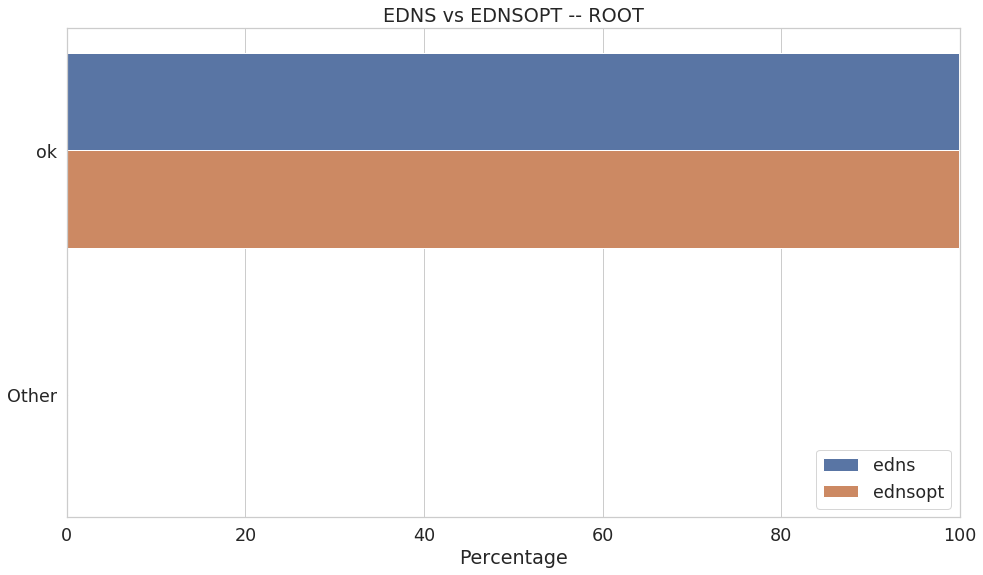

In [547]:
plot_comparison(data=s_edns_ednsopt, title='EDNS vs EDNSOPT -- %s', file_prefix='{zone}/{zone}-EDNS-EDNSOPT-{date}',
                loc=LOC_DATA)

In [548]:
s_edns_ednsopt

,error_type,perc,domain,test,zone
1,ok,99.883586,6864,edns,ROOT
0,Other,0.116414,8,edns,ROOT
1,ok,99.898137,6865,ednsopt,ROOT
0,Other,0.101863,7,ednsopt,ROOT


### Compare results of 'edns1' and 'edns1opt' tests when dns=ok and edns1=ok

In [549]:
s_edns1opt = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns1']=='ok')], fields=['edns1', 'edns1opt'])

Column = edns1
Column = edns1opt


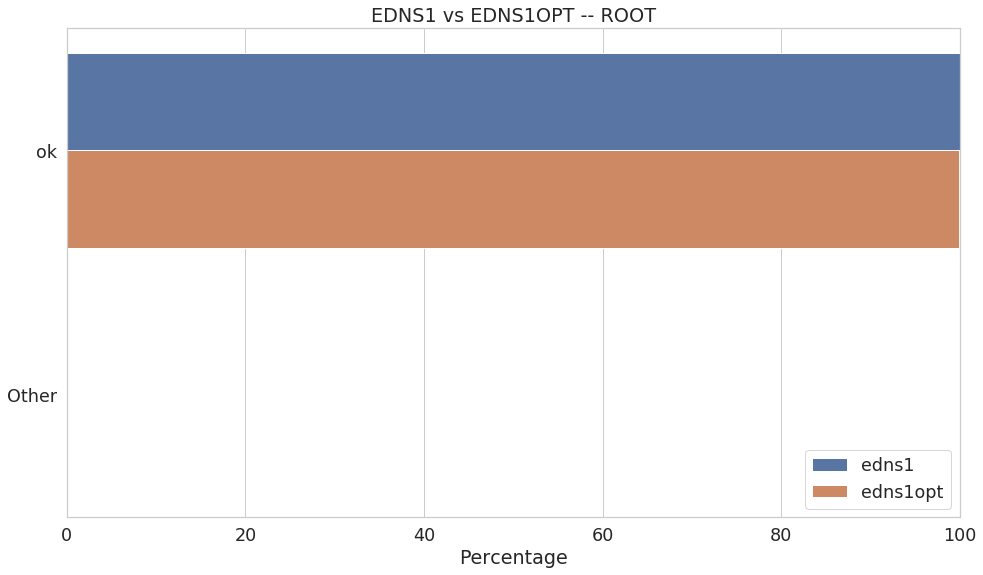

In [550]:
plot_comparison(data=s_edns1opt, title='EDNS1 vs EDNS1OPT -- %s', file_prefix='{zone}/{zone}-EDNS1-EDNS1OPT-{date}',
                loc=LOC_DATA)

### Compare results of 'do' and 'edns' 

In [551]:
s_do_edns = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')], fields=['edns', 'do'])

Column = edns
Column = do


In [552]:
s_do_edns

,error_type,perc,domain,test
0,ok,100.000000,6864,edns
1,ok,99.927156,6859,do
0,Other,0.072844,5,do


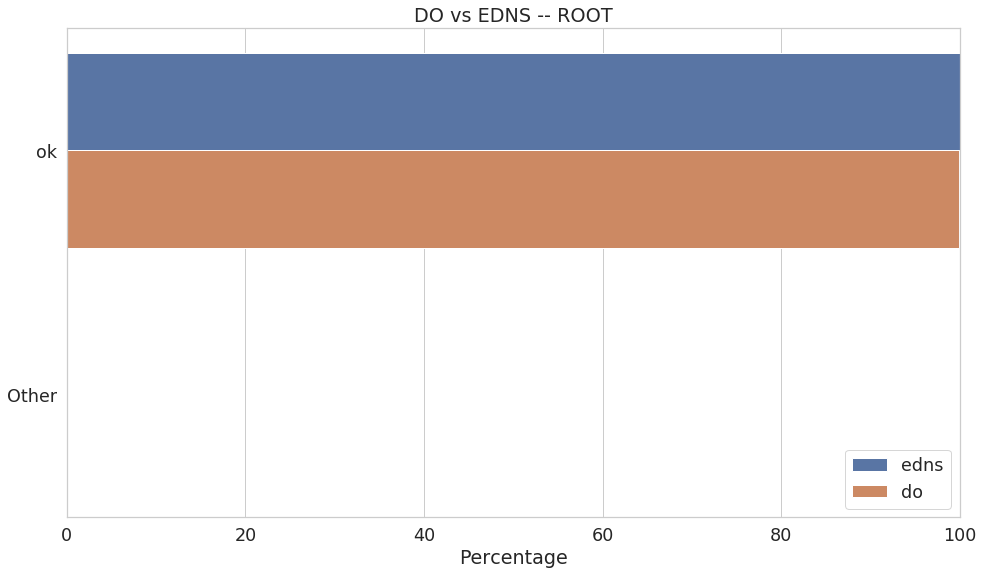

In [553]:
plot_comparison(data=s_do_edns, title='DO vs EDNS -- %s', file_prefix='{zone}/{zone}-DO-EDNS-{date}', loc=LOC_DATA)

### Compare results of 'do', 'ednstcp', 'edns@512' when edns=ok and do=ok

In [554]:
s_ednstcp = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok') & (d['do']=='ok')],
                                   fields=['do', 'ednstcp', 'edns@512'])

Column = do
Column = ednstcp
Column = edns@512


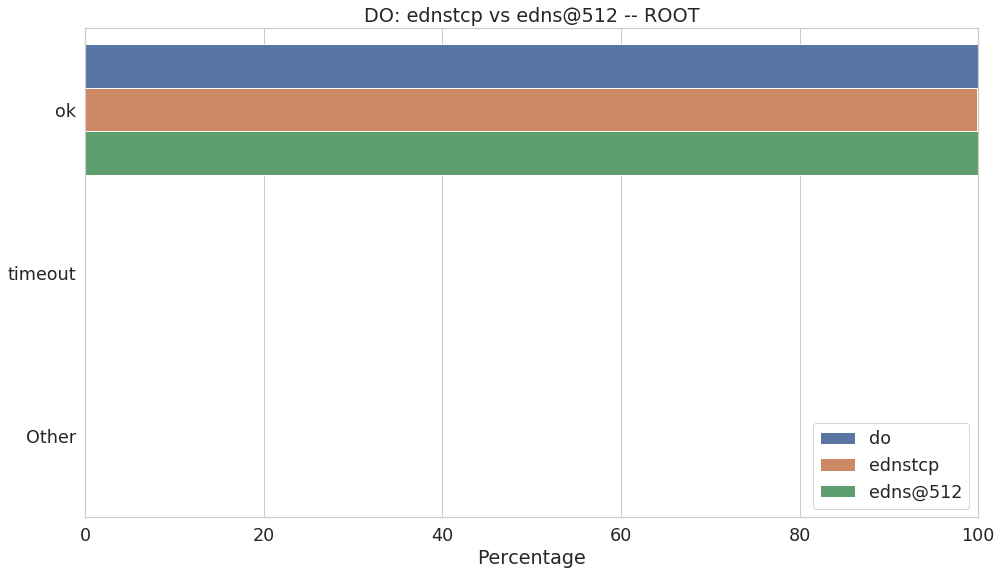

In [555]:
plot_comparison(data=s_ednstcp, title='DO: ednstcp vs edns@512 -- %s',
                file_prefix='{zone}/{zone}-do-ednstcp-edns512-{date}', loc=LOC_DATA)

### Compare 'edns' with 'ednsflags' when edns=ok

In [556]:
s_ednsflags = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'ednsflags'])

Column = edns
Column = ednsflags


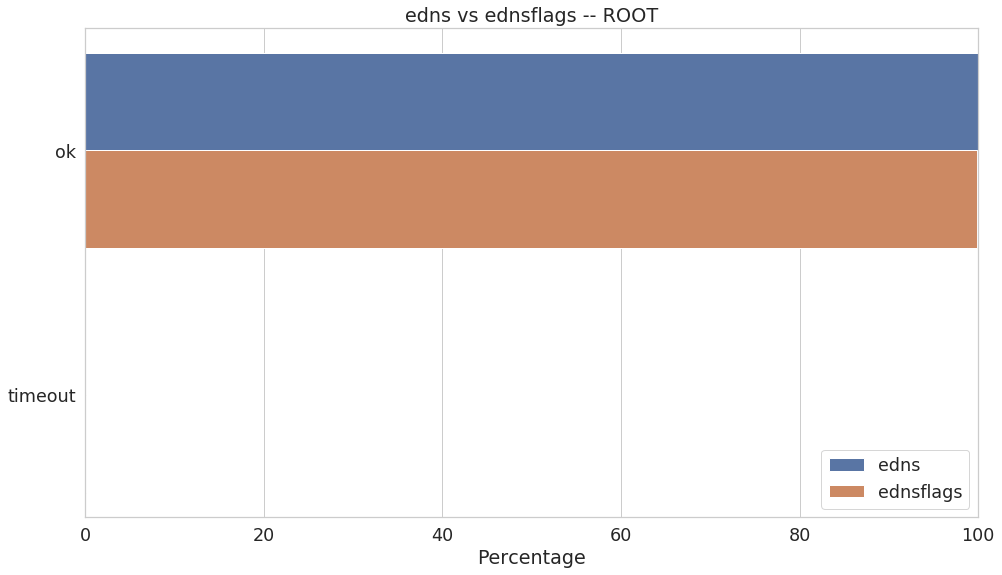

In [557]:
plot_comparison(data=s_ednsflags, title='edns vs ednsflags -- %s',
                file_prefix='{zone}/{zone}-edns-ednsflags-{date}', loc=LOC_DATA)

### Compare edns with optlist when edns=ok

In [558]:
s_optlist = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'optlist'])

Column = edns
Column = optlist


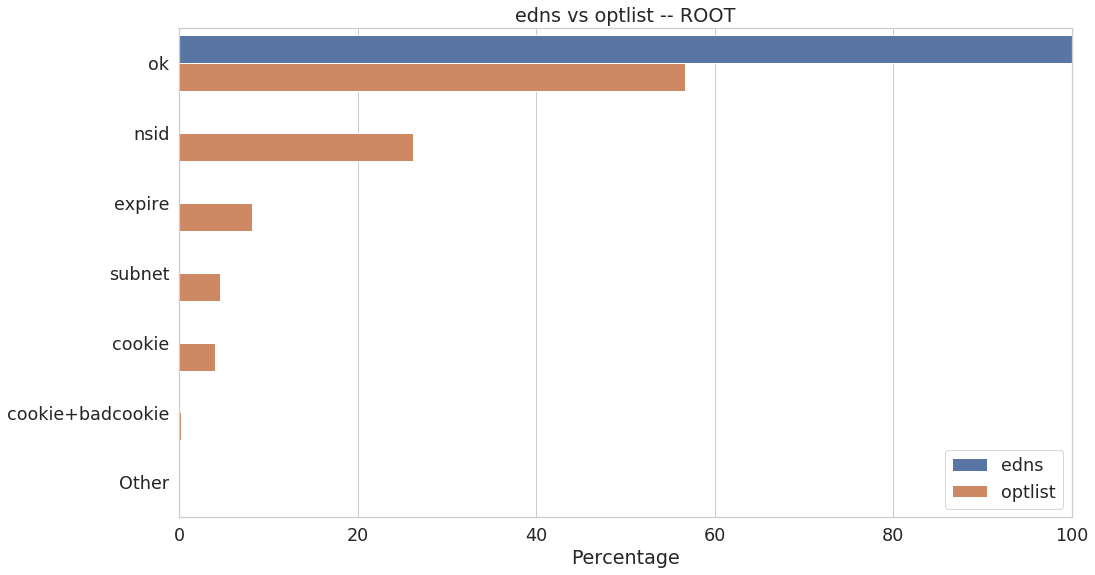

In [559]:
plot_comparison(data=s_optlist, title='edns vs optlist -- %s',
                file_prefix='{zone}/{zone}-edns-optlist-{date}', loc=LOC_DATA)

### Calculate a correctness score per server/address pair

In [560]:
d.columns

Index(['address', 'aa', 'ad', 'cd', 'dns', 'do', 'docd', 'domain', 'edns',
       'edns1', 'edns1cookie', 'edns1do', 'edns1expire', 'edns1nsid',
       'edns1opt', 'edns1subnet', 'edns@512', 'ednscookie', 'ednsexpire',
       'ednsflags', 'ednsnsid', 'ednsopt', 'ednssubnet', 'ednstcp', 'opcode',
       'opcodeflg', 'optlist', 'ra', 'rd', 'server', 'signed', 'src_file',
       'tc', 'tcp', 'type666', 'zflag', 'family'],
      dtype='object')

In [561]:
sel_fields = [c for c in d.columns if c not in ['signed', 'src_file']]
d2 = d[sel_fields].melt(id_vars=['server', 'address', 'domain', 'family'])

In [562]:
d2[d2['value'].str.contains('ok')]['value'].unique()

array(['ok', 'ok,nsid', 'ok,cookie', 'ok,cookie+badcookie', 'ok,expire',
       'ok,subnet', 'ok,nsid,expire,cookie,subnet', 'ok,nsid,expire',
       'ok,expire,cookie,subnet', 'ok,expire,cookie',
       'ok,nsid,cookie+badcookie,subnet', 'ok,nsid,subnet',
       'ok,expire,subnet', 'ok,cookie+badcookie,subnet',
       'ok,nsid,expire,subnet', 'ok,nsid,expire,cookie'], dtype=object)

In [563]:
dual_server_series = d2.drop_duplicates(subset=['server', 'address', 'family']).groupby('server').apply(lambda x: len(set(x['family'])))

In [564]:
dual_server_names = dual_server_series[dual_server_series==2].index
dual_stack_count = len(dual_server_names)

In [565]:
# For nameservers that have multiple v4 and/or v6 addresses, generate a unique result of the address family
# by picking the most frequent (mode) result for each column
_fields = [c for c in d.columns if c not in ['signed', 'address', 'domain', 'src_file']]
d3 = d[d2.server.isin(dual_server_names.tolist())][_fields]
# d = d0.groupby(['address']).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()

/opt/a/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [566]:
d3.head()

,aa,ad,cd,dns,do,docd,edns,edns1,edns1cookie,edns1do,...,opcodeflg,optlist,ra,rd,server,tc,tcp,type666,zflag,family
0,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,...,"rd,cd",ok,ok,ok,(e.dns.id.):,ok,ok,ok,ok,v4
1,ok,ok,ok,ok,ok,nocd,ok,ok,ok,ok,...,"formerr,rd",ok,ok,ok,(c.dns.id.):,ok,ok,ok,ok,v4
2,ok,ok,ok,ok,ok,nocd,ok,ok,ok,ok,...,"formerr,rd",ok,ok,ok,(b.dns.id.):,ok,ok,ok,ok,v4
3,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,...,"rd,cd","ok,nsid",ok,ok,(tld4.nic.jprs.):,ok,ok,ok,ok,v4
4,ok,ok,ok,ok,ok,ok,ok,ok,ok,ok,...,"rd,cd",ok,ok,ok,(ns4.admin.net.):,ok,ok,ok,ok,v4


In [567]:
d3b = d3.groupby(['server', 'family']).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()\
    .melt(id_vars=['server', 'family'])
d3b.columns = ['server', 'family', 'test', 'test_value']

/opt/a/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [568]:
d3b.head(10)

,server,family,test,test_value
0,(1.ns.ph.):,v4,aa,ok
1,(1.ns.ph.):,v6,aa,ok
2,(a-dns.pl.):,v4,aa,ok
3,(a-dns.pl.):,v6,aa,ok
4,(a.aq.dyntld.net.):,v4,aa,ok
5,(a.aq.dyntld.net.):,v6,aa,ok
6,(a.au.):,v4,aa,ok
7,(a.au.):,v6,aa,ok
8,(a.dns-servers.vn.):,v4,aa,ok
9,(a.dns-servers.vn.):,v6,aa,ok


In [569]:
d3c = d3b.set_index(['server', 'family', 'test']).unstack('family').reset_index()
d3c.columns=['server', 'test', 'v4', 'v6']

In [570]:
differing = d3c[d3c['v4']!=d3c['v6']]

In [571]:
dual_stack_divergent_cnt = len(differing['server'].unique())

In [572]:
pd.DataFrame(differing['test'].value_counts()).reset_index().to_json('{zone}/{zone}-differing-test-count-per-family-{date}.json'.format(**LOC_DATA))

In [573]:
differing.groupby(['test', 'v4', 'v6']).count().reset_index().to_json('{zone}/{zone}-differing-test-values-per-family-{date}.json'.format(**LOC_DATA))

In [574]:
d2['score'] = d2['value'].apply(lambda x: 1.0 if x=='ok' else 0.8 if 'ok' in x else 0.0)

In [575]:
d2.head()

,server,address,domain,family,variable,value,score
0,(e.dns.id.):,@103.19.177.177,id.,v4,aa,ok,1.0
1,(c.dns.id.):,@103.19.178.178,id.,v4,aa,ok,1.0
2,(b.dns.id.):,@103.19.179.179,id.,v4,aa,ok,1.0
3,(tld4.nic.jprs.):,@103.198.210.1,jprs.,v4,aa,ok,1.0
4,(ns4.admin.net.):,@103.25.58.26,tg.,v4,aa,ok,1.0


In [576]:
BINS=10
def hist2df(data=None, col_name=None, col_value=None, col_cnt_name='server_cnt'):
    bin_range = np.arange(0.0, 1.01, 1.0/BINS)
    range_fmt = "[{0[0]:.1f}-{0[1]:.1f})"
    end_range_fmt = "[{0[0]:.1f}-{0[1]:.1f}]"
    bin_labels = [range_fmt.format(bin_range[i:i+2]) for i in range(0, len(bin_range)-2)] + [end_range_fmt.format(bin_range[-2:])]
    out, bins  = pd.cut(data, bins=bin_range, labels=bin_labels, include_lowest=True, right=True, retbins=True)
    df = pd.DataFrame(out.value_counts(sort=False))
    df.columns = [col_cnt_name]
    df['fraction'] = 100 * (df[col_cnt_name] / df[col_cnt_name].sum())
    df['fraction_cum'] = df['fraction'].cumsum()
    if col_name is not None:
        df[col_name] = col_value
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'bin'}, inplace=True)
    return df

In [577]:
server_score = d2.groupby(['server'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()
server_score_hist = hist2df(server_score['score'])
server_score_hist.to_json('{zone}/{zone}-server-score-histogram-{date}.json'.format(**LOC_DATA))

Text(0.5,1,'ROOT -- Server score distribution')

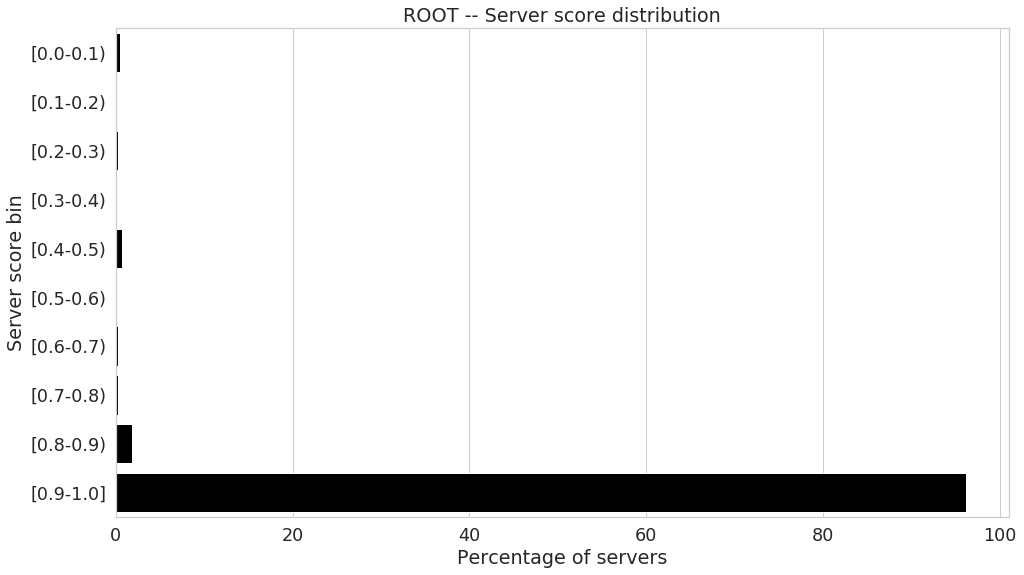

In [578]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_score_hist, x='fraction', y='bin', color='black', saturation=0.9)
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- Server score distribution' % ZONE)

In [579]:
server_fam_score = d2.groupby(['server', 'family'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [580]:
server_fam_score.head()

,server,family,score
0,(1.ns.ph.):,v4,0.954839
1,(1.ns.ph.):,v6,0.954839
2,(a-dns.pl.):,v4,0.980645
3,(a-dns.pl.):,v6,0.980645
4,(a.aq.dyntld.net.):,v4,0.916129


In [581]:
server_fam_score['server'].nunique()

3654

In [582]:
n_server

3654

In [583]:
server_fam_score.query("family=='v4'")['server'].nunique()

3648

In [584]:
server_fam_score.query("family=='v6'")['server'].nunique()

3272

In [585]:
# Servers with IPv6-only addresses
ipv6_only_server = len(set(server_fam_score.query("family=='v6'")['server'].unique())-set(server_fam_score.query("family=='v4'")['server'].unique()))

In [586]:
# Servers with IPv6-only addresses
ipv4_only_server = len(set(server_fam_score.query("family=='v4'")['server'].unique())-set(server_fam_score.query("family=='v6'")['server'].unique()))

In [587]:
server_fam_score_hist = pd.concat([hist2df(data=server_fam_score.query("family=='v4'")['score'], col_name='family', col_value='v4'),
                                   hist2df(data=server_fam_score.query("family=='v6'")['score'], col_name='family', col_value='v6')]).reset_index()
server_fam_score_hist['zone'] = ZONE
server_fam_score_hist.to_json('{zone}/{zone}-server-score-histogram-per-address-family-{date}.json'.format(**LOC_DATA))

Text(0.5,1,'ROOT -- nameserver score distribution per address family')

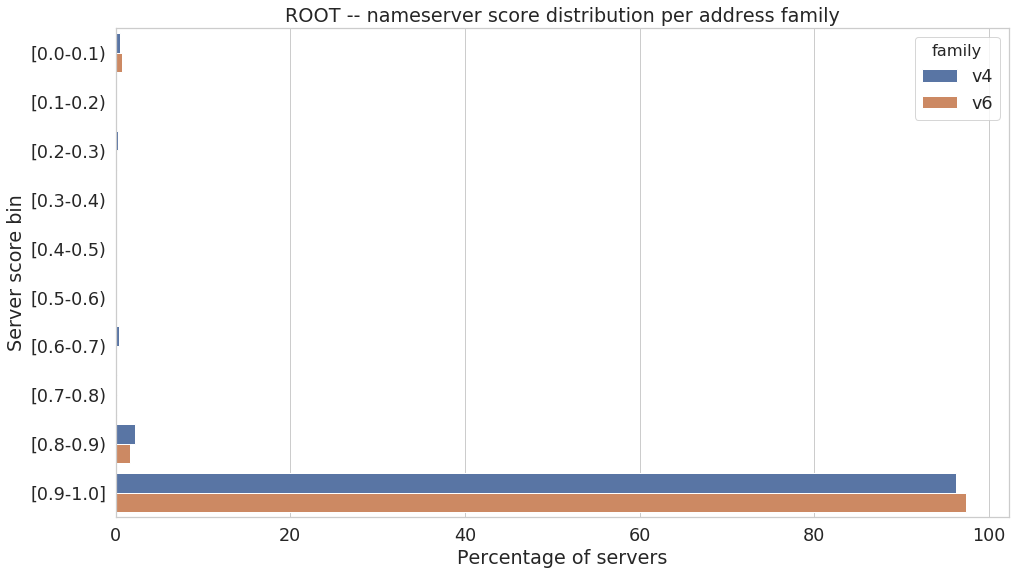

In [588]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_fam_score_hist, y='bin', x='fraction', hue='family')
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- nameserver score distribution per address family' % ZONE)

In [589]:
server_dual_stack_score = d2.groupby(['server', 'family'])['score'].apply(lambda x: x.sum()/len(x)).reset_index().pivot_table(index='server', columns='family', values='score').dropna().reset_index()

In [590]:
server_dual_stack_score.head(5)

family,server,v4,v6
0,(1.ns.ph.):,0.954839,0.954839
1,(a-dns.pl.):,0.980645,0.980645
2,(a.aq.dyntld.net.):,0.916129,0.980645
3,(a.au.):,0.954839,0.954839
4,(a.dns-servers.vn.):,0.870968,0.870968


In [591]:
server_dual_stack_score_hist = pd.concat([hist2df(data=server_dual_stack_score['v4'], col_name='family', col_value='v4'),
                                   hist2df(data=server_dual_stack_score['v6'], col_name='family', col_value='v6')]).reset_index()
server_dual_stack_score_hist['zone'] = ZONE
server_dual_stack_score_hist.to_json('{zone}/{zone}-dual-stack-server-score-histogram-{date}.json'.format(**LOC_DATA))

In [592]:
server_dual_stack_score_hist.head()

,index,bin,server_cnt,fraction,fraction_cum,family,zone
0,0,[0.0-0.1),4,0.122474,0.122474,v4,ROOT
1,1,[0.1-0.2),2,0.061237,0.183711,v4,ROOT
2,2,[0.2-0.3),4,0.122474,0.306185,v4,ROOT
3,3,[0.3-0.4),0,0.000000,0.306185,v4,ROOT
4,4,[0.4-0.5),1,0.030618,0.336803,v4,ROOT


Text(0.5,1,'ROOT -- dual-stack nameserver score distribution')

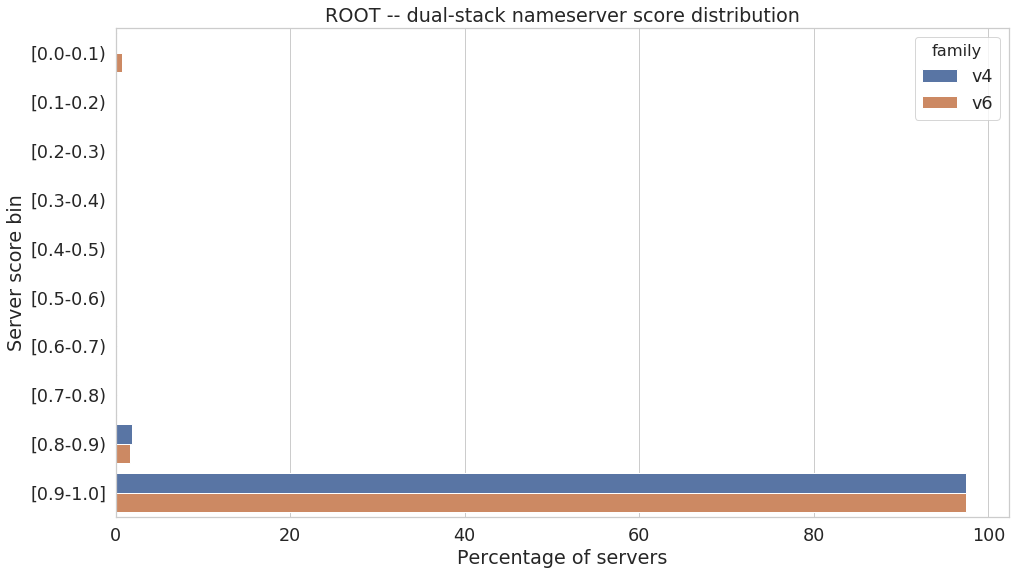

In [593]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_dual_stack_score_hist, y='bin', x='fraction', hue='family')
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- dual-stack nameserver score distribution' % ZONE)

In [594]:
# Identify the servers that have both IPv4 and IPv6 for a fair comparison


In [595]:
domain_score = d2.groupby(['domain'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [596]:
domain_score_hist = hist2df(data=domain_score['score'], col_cnt_name='dom_cnt').reset_index()

Text(0.5,1,'ROOT -- Domain score distribution')

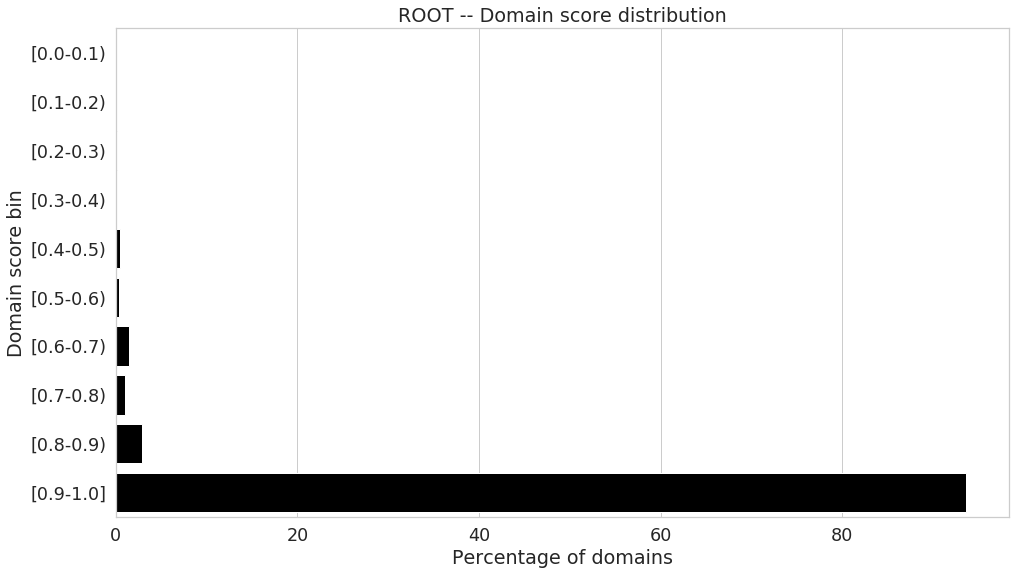

In [597]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=domain_score_hist, x='fraction', y='bin', color='black', saturation=0.9)
ax.set_xlabel('Percentage of domains')
ax.set_ylabel('Domain score bin')
ax.set_title('%s -- Domain score distribution' % ZONE)


In [598]:
domain_score_hist.to_json('{zone}/{zone}-domain-score-histogram-{date}.json'.format(**LOC_DATA))

In [599]:
# Generate the summary of certain tests to compare with ISC results
pd.concat([
    s_dns_edns.query("(test=='edns') & (error_type=='ok')"),
    s_edns_ednsopt.query("(test=='ednsopt') & (error_type=='ok')"),
    s_edns_edns1.query("(test=='edns1') & (error_type=='ok')"),
    s_do_edns.query("(test=='do') & (error_type=='ok')"),
    s_optlist.query("(test=='optlist') & (error_type=='nsid')")
]).reset_index().to_json("{zone}/{zone}-comparative-metrics-{date}.json".format(**LOC_DATA))

In [600]:
gen_stats = pd.DataFrame([('# domains', n_dom),
                          ('# servers', n_server),
                          ('# dual stack server', dual_stack_count),
                          ('# mismatch dual stack server', dual_stack_divergent_cnt),
                          ('# IPv6-only servers', ipv6_only_server),
                          ('# IPv4-only servers', ipv4_only_server),
                         ('Unique addresses', n_addr),
                         ('Unique v4 addresses', uniq_v4_addr),
                         ('Unique v6 addresses', uniq_v6_addr)], columns=['Metric', 'Value'])
gen_stats['zone'] = ZONE
gen_stats.to_json('{zone}/{zone}-general-stats-{date}.json'.format(**LOC_DATA))